#### Correlation between the 2021 Super Bowl and a possible rise in cases of COVID-19

In [86]:
import pandas as pd
from datetime import date, timedelta
import piecewise_regression
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc as pm
import arviz as az
import numpy as np
#import theano
import sdt.changepoint as c

In [87]:
file_path = "./covid_confirmed_usafacts.csv"
# Read the CSV file using pandas
dataframe = pd.read_csv(file_path)
#get rid of all the rows with county name = Statewide Unallocated
dataframe = dataframe[dataframe['County Name'] != 'Statewide Unallocated']
#get rid of all the rows with county name = Out of Country
dataframe = dataframe[dataframe['County Name'] != 'Out of Country']

In [88]:
#CREATION OF THE DATAFRAME
# Specify the file path or URL of the CSV file

#restrict the date range to 2021-01-23 to 2021-02-23 but keep state, countyFIPS and StateFIPS
#aggregate by state
grouped = dataframe.groupby('State').sum()
#rename the grouped column as State
grouped = grouped.rename_axis('State').reset_index()
partGrouped = grouped[["State"]]
start_date = date(2021, 1, 24) #moving average starts having values on the 24th of January
super_bowl_date = date(2021, 2, 7)

difference = super_bowl_date - start_date


end_date = date(2021, 3, 7)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta
listdays = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    listdays.append(day.strftime("%Y-%m-%d"))
#istdays.insert(0, 'State')
otherGrouped = grouped[listdays]
#join the two dataframes
grouped = pd.concat([partGrouped, otherGrouped], axis=1)
grouped = grouped.T
grouped.columns = grouped.iloc[0]
grouped = grouped.iloc[1: , :]
grouped.rename(columns = {'State':'Date'}, inplace = True )
grouped.head()

dataframe_list = []
print(grouped.columns)
for col in grouped.columns[1:]:
    dataframe_list.append(grouped[[col]])

for d in dataframe_list:
    #add colun with moving average for each day
    d['MA'] = d.rolling(window=7).mean()
    #add column with the difference between the moving average of the current day and the moving average of the previous day
    d['Diff'] = d['MA'].diff()
    d.dropna(inplace=True)

print(dataframe_list[33])


Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='State')
State            NY            MA          Diff
2021-01-31  1410656  1.374598e+06  11952.714286
2021-02-01  1419164  1.386051e+06  11453.428571
2021-02-02  1427379  1.397098e+06  11046.428571
2021-02-03  1433304  1.407415e+06  10317.428571
2021-02-04  1440718  1.416878e+06   9462.571429
2021-02-05  1449495  1.425797e+06   8919.428571
2021-02-06  1449495  1.432887e+06   7090.285714
2021-02-07  1470772  1.441475e+06   8588.000000
2021-02-08  1479220  1.450055e+06   8579.428571
2021-02-09  1487086  1.458584e+06   8529.571429
2021-02-10  1494187  1.467282e+06   8697.571429
2021-02-11  1504286  1.476363e+06   9081.14285

C:\Users\Simone\AppData\Local\Temp\ipykernel_14212\55663873.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['MA'] = d.rolling(window=7).mean()
C:\Users\Simone\AppData\Local\Temp\ipykernel_14212\55663873.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Diff'] = d['MA'].diff()
C:\Users\Simone\AppData\Local\Temp\ipykernel_14212\55663873.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

OUT  [13]


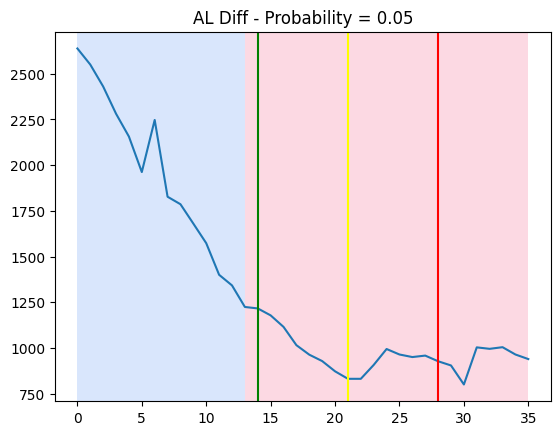

OUT  [13]


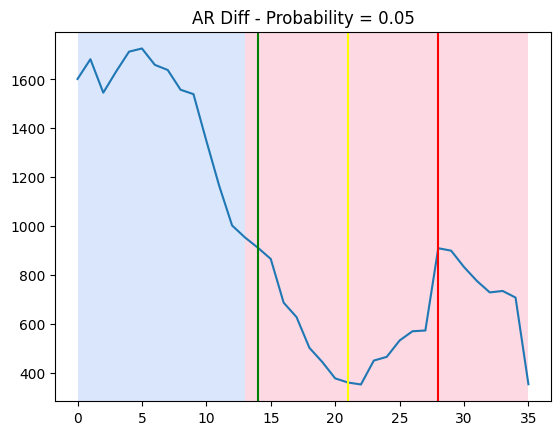

OUT  [15]


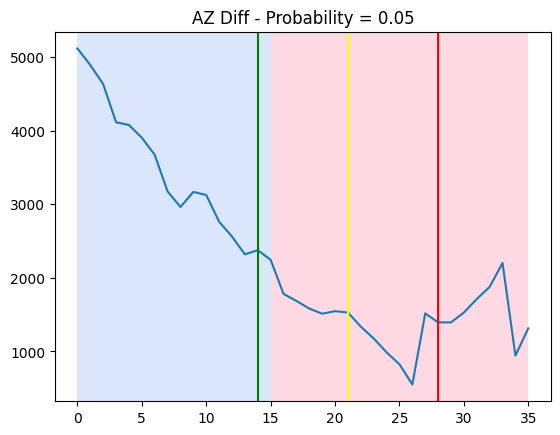

OUT  [17]


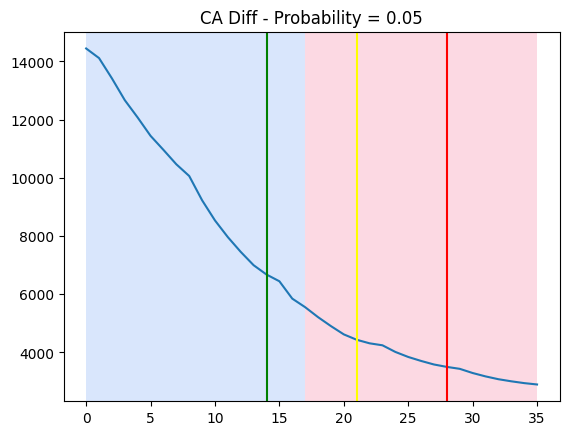

OUT  [ 1 14]


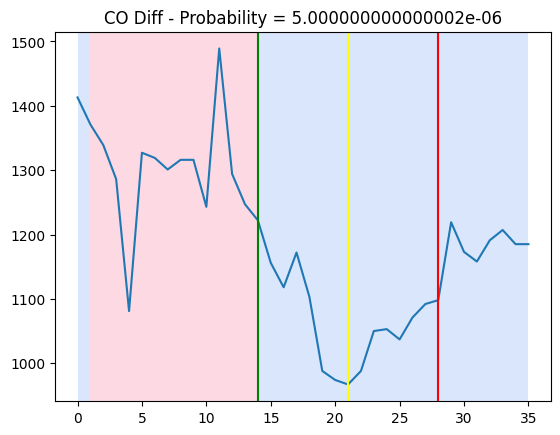

OUT  [15]


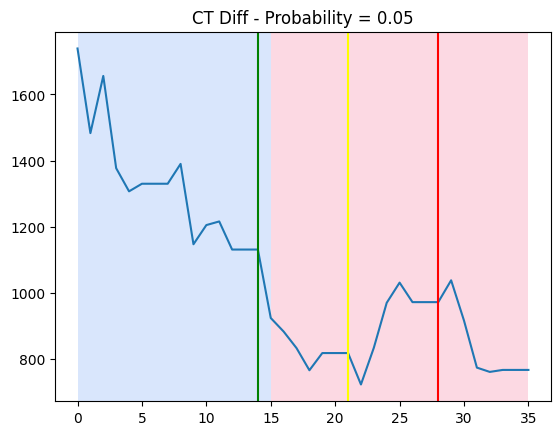

OUT  [12]


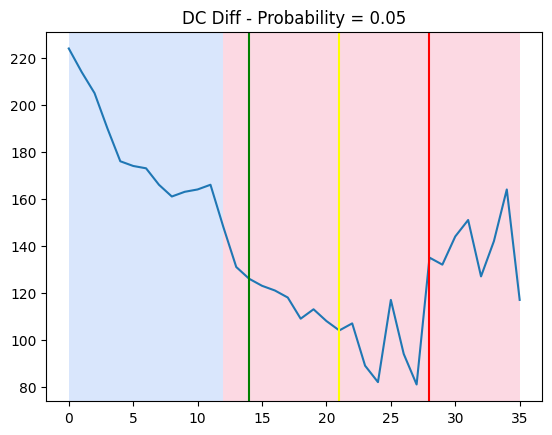

OUT  [17]


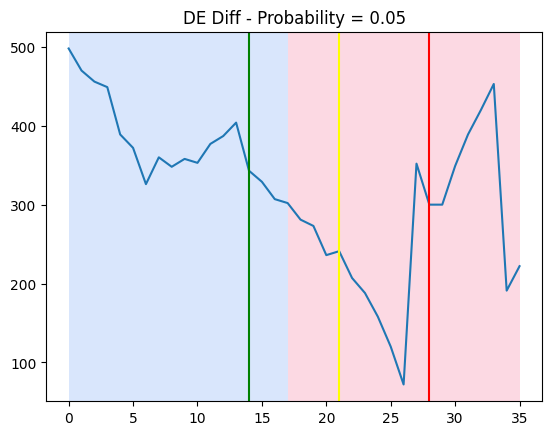

OUT  [14]


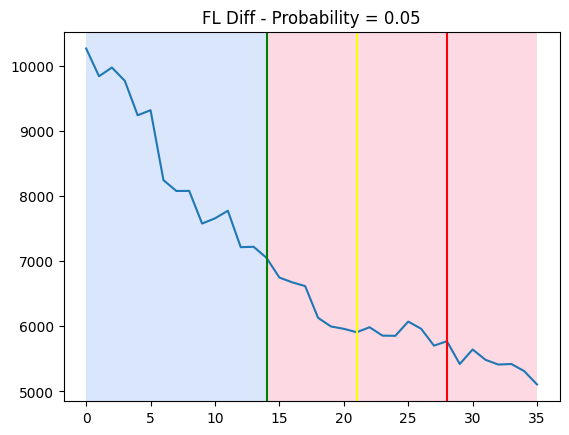

OUT  [14]


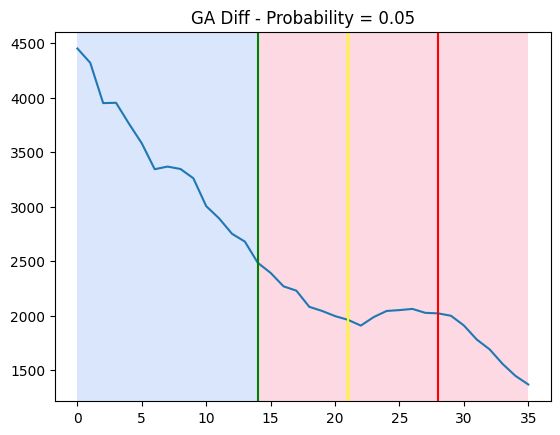

OUT  [13]


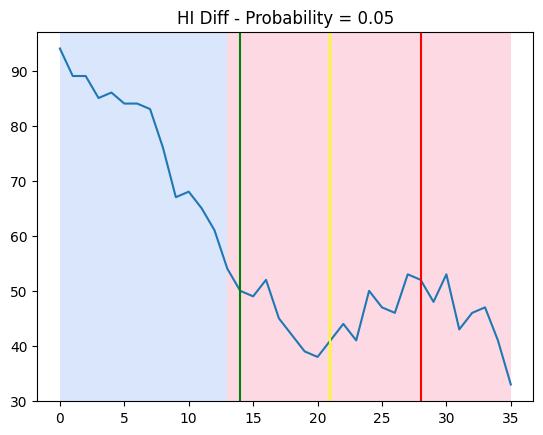

OUT  [17]


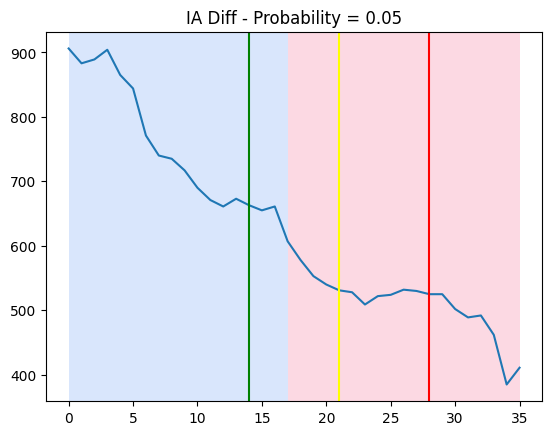

OUT  [14]


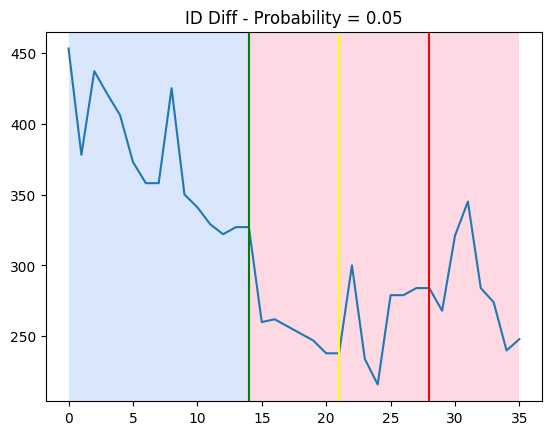

OUT  [15]


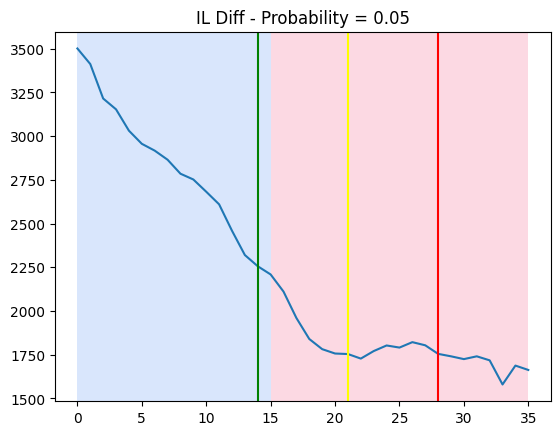

OUT  [17]


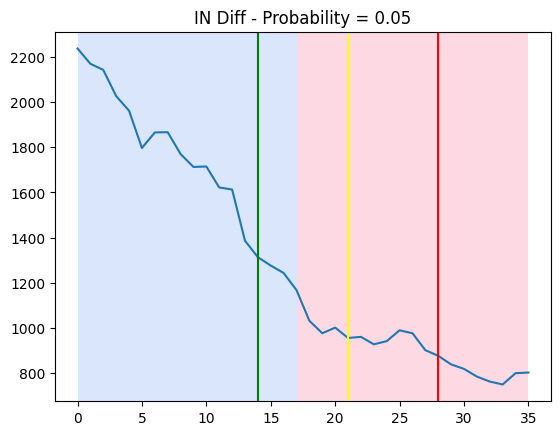

OUT  [12 26]


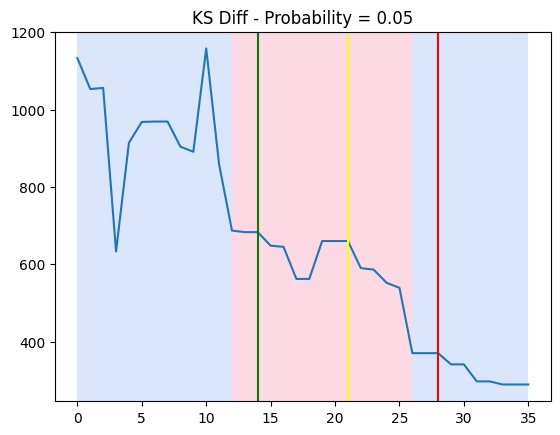

OUT  [16]


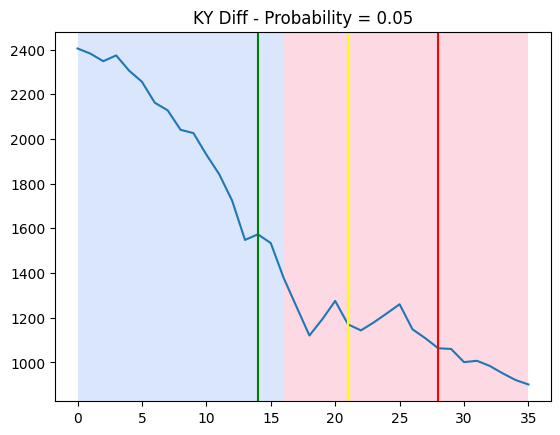

OUT  [15]


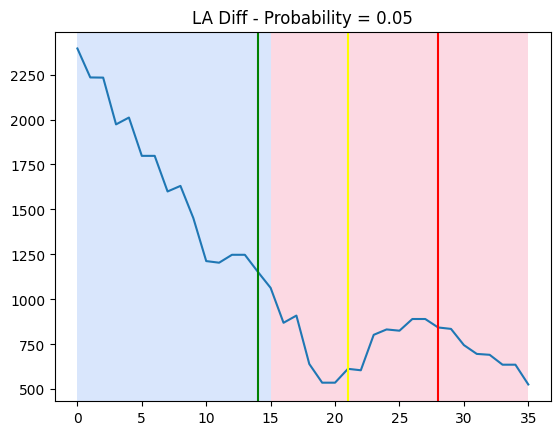

OUT  [14]


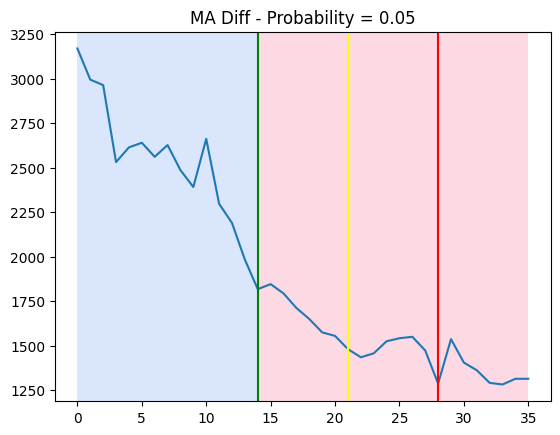

OUT  [15]


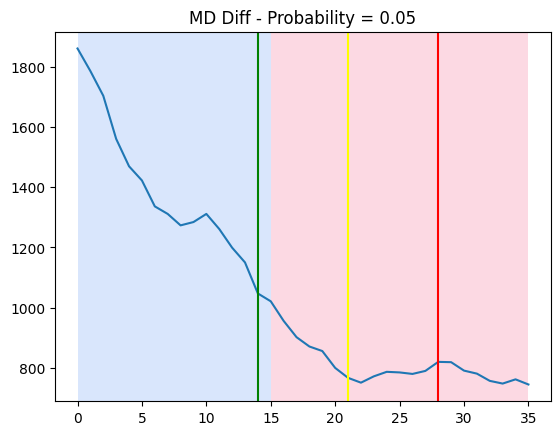

OUT  [ 9 13]


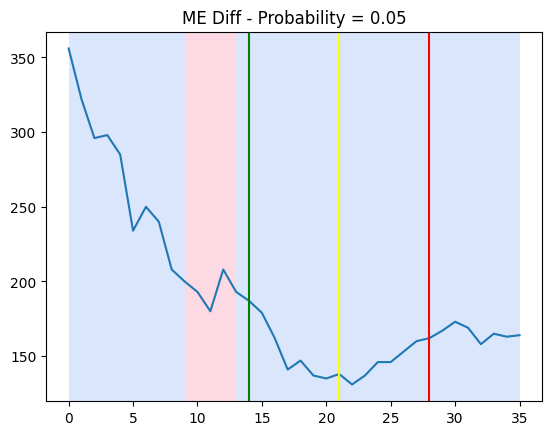

OUT  [8]


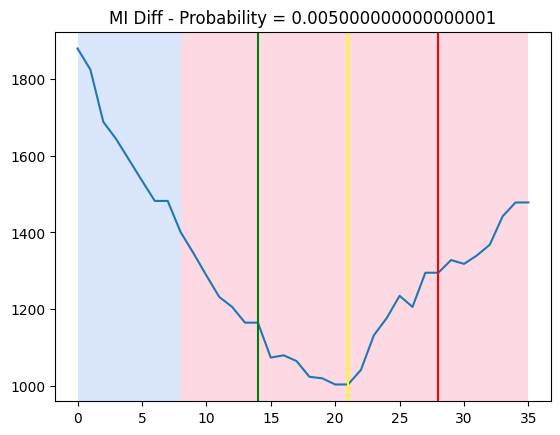

OUT  [3 8]


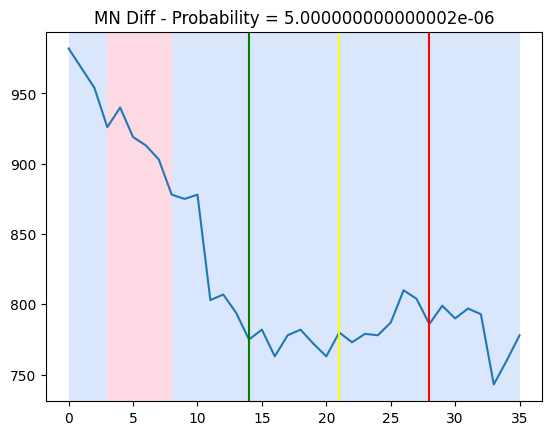

OUT  [15]


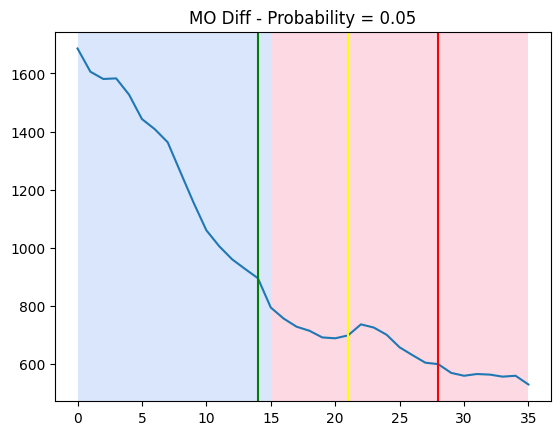

OUT  [18]


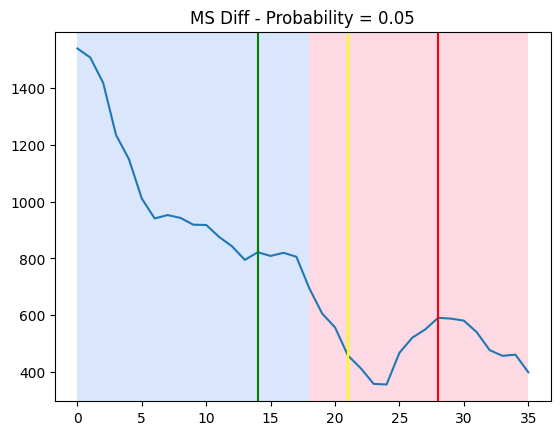

OUT  [16]


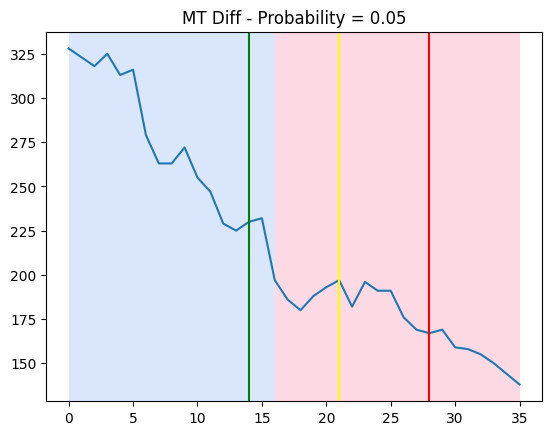

OUT  [15]


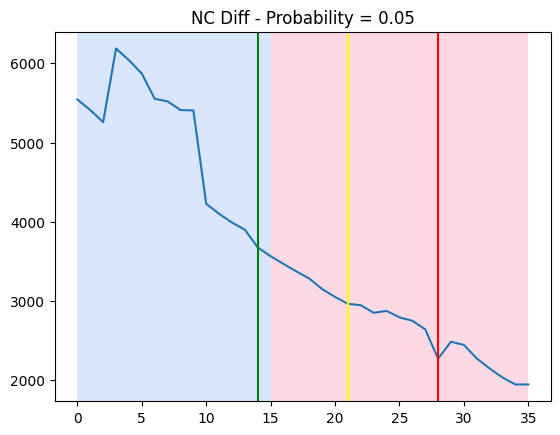

OUT  [ 5 16 23]


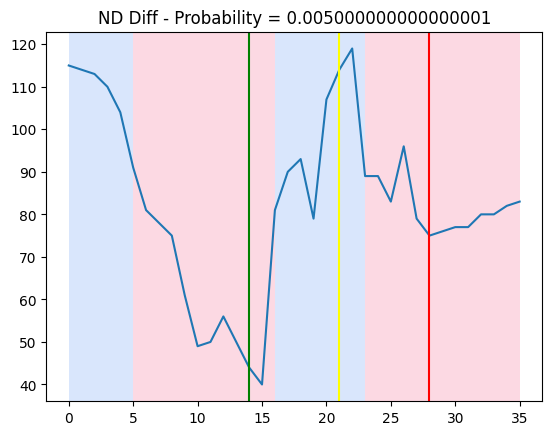

OUT  [19]


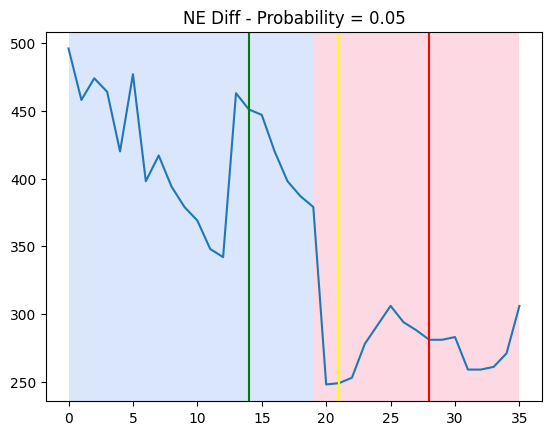

OUT  [25 28 30]


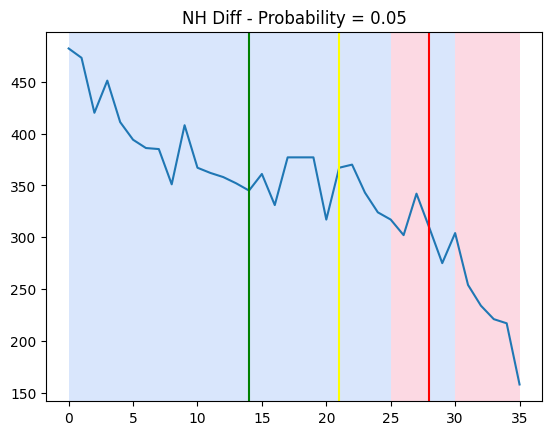

OUT  [ 5 14]


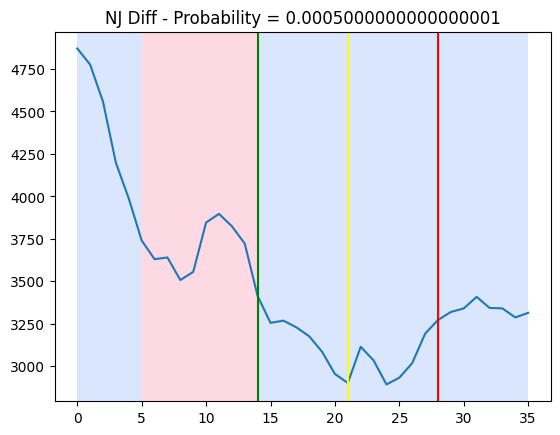

OUT  [16]


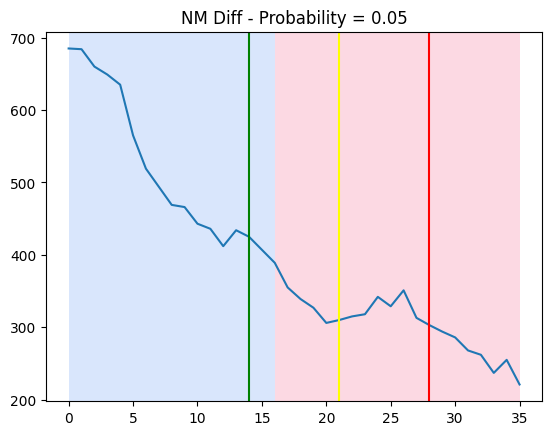

OUT  [17]


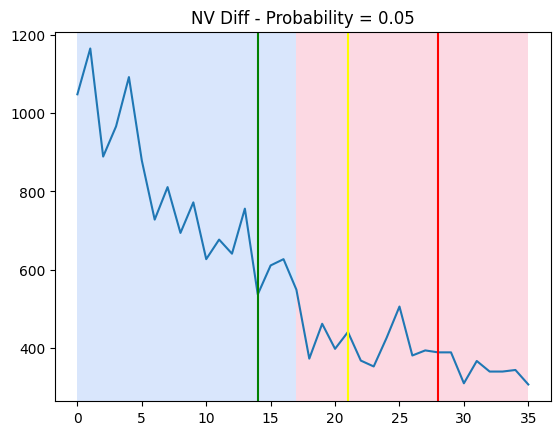

OUT  [14]


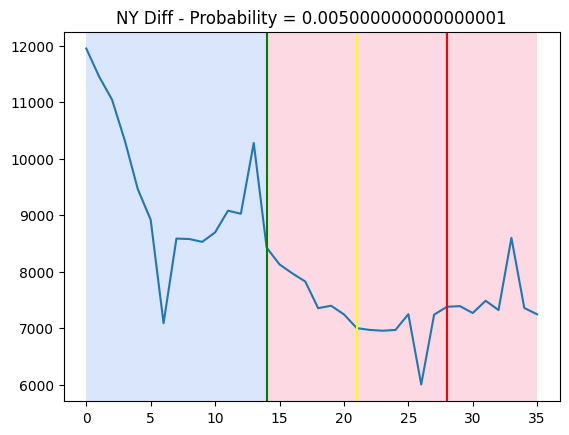

OUT  [16]


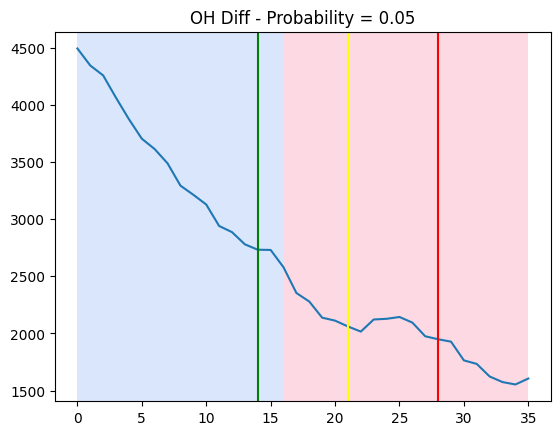

OUT  [18]


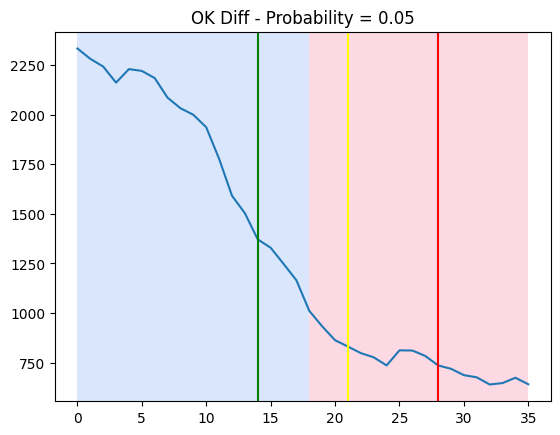

OUT  [14]


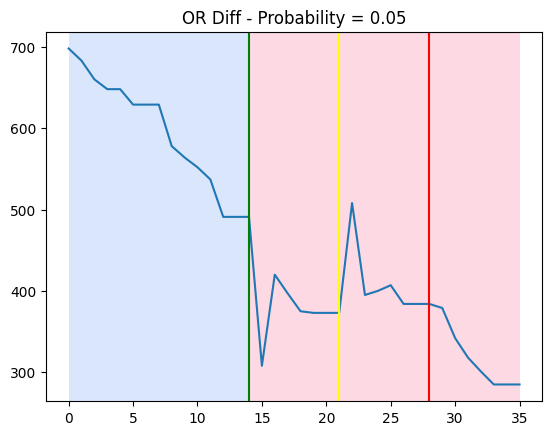

OUT  [16]


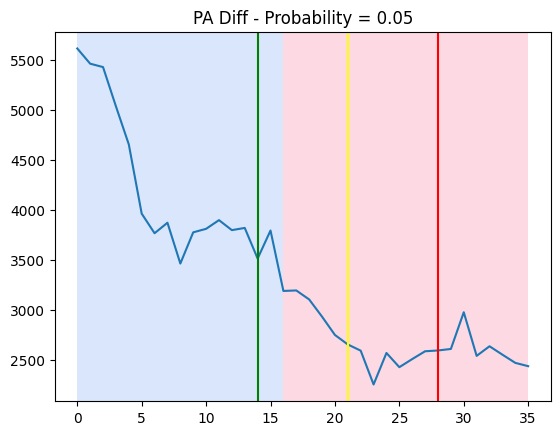

OUT  [10 16]


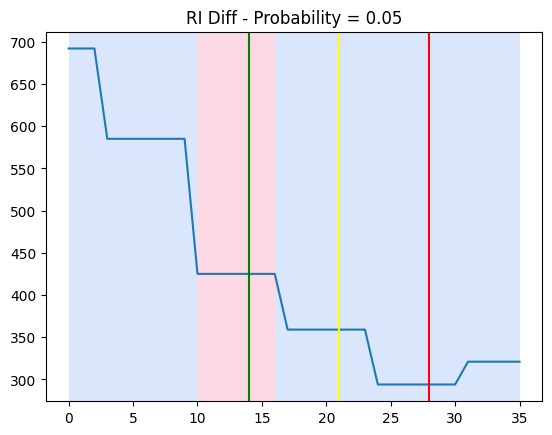

OUT  [26]


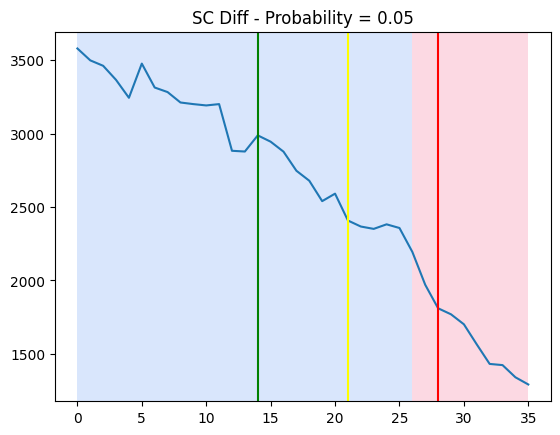

OUT  [ 6 29]


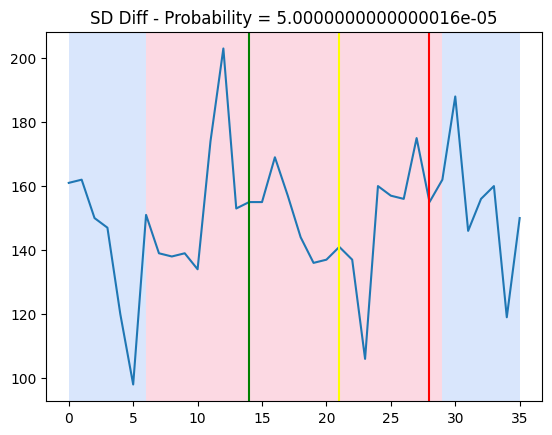

OUT  [17]


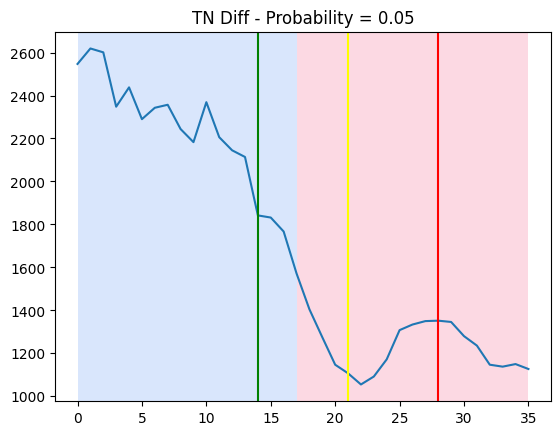

OUT  [16]


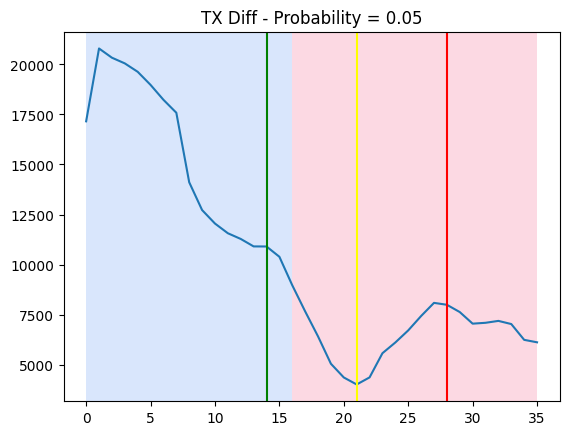

OUT  [17]


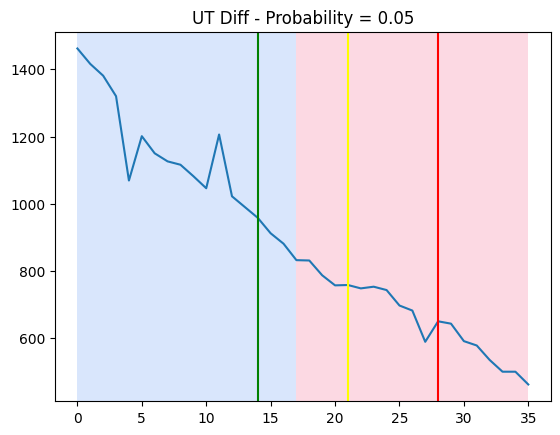

OUT  [19]


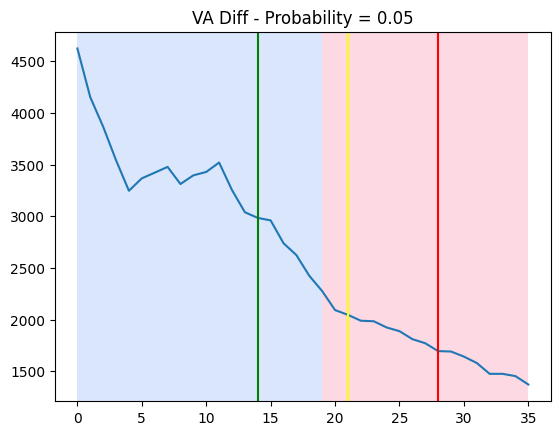

OUT  [ 1 10 21 24]


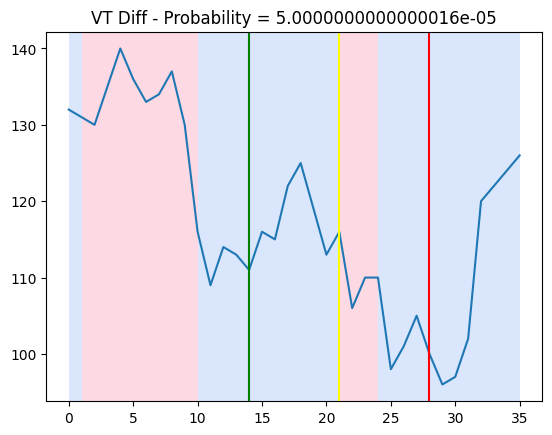

OUT  [14]


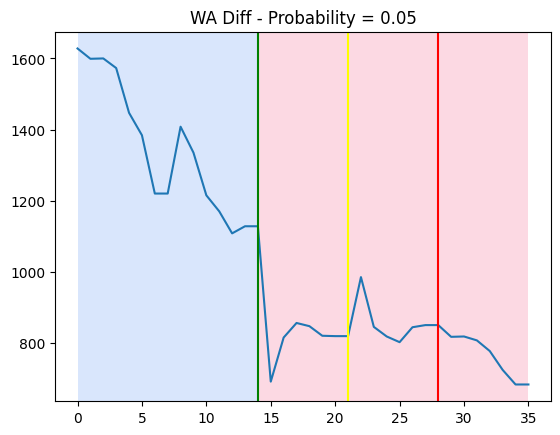

OUT  [14]


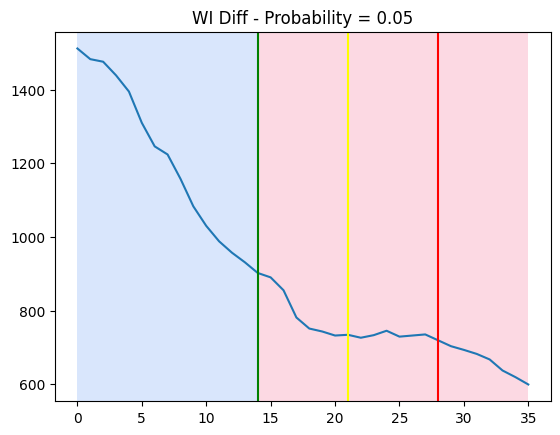

OUT  [16]


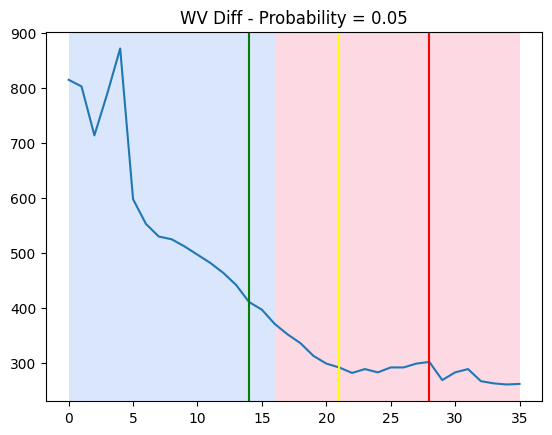

OUT  [10]


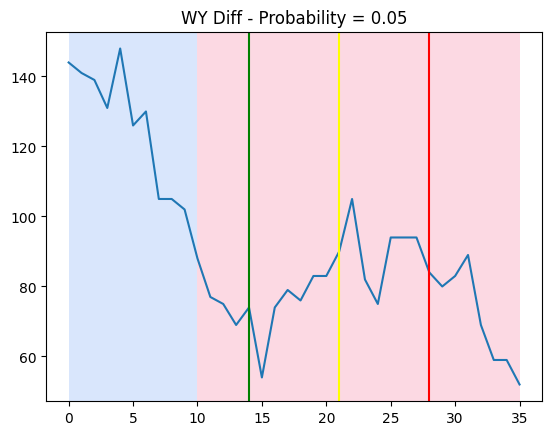

In [93]:
BayesOffline = c.BayesOffline()

for df in dataframe_list:
    df = df.astype(int)

    try:
        values = df[df.columns.values[2]].values
    except:
        values = df[df.columns.values[1]].values

    # Out is a list of possible changepoint "indices"
    prob = 0.5
    out = []
    while len(out) == 0:
        prob = prob * 0.1
        out = BayesOffline.find_changepoints(values, prob_threshold=prob)
    #print(out)
    # If there is a changepoint.
    #if len(out) > 0:
    print("OUT ", out)
    '''print("Q ", q)
    print("P ", p)
    print("PCP ",pcp)'''
    # Plot the data.
    c.plot_changepoints(values, out)
    #plt.plot(values)
    try:
        plt.title(df.columns.values[0] + " " + df.columns.values[2] + " - Probability = " + str(prob))
    except:
        plt.title(df.columns.values[0] + " " + df.columns.values[1] + " - Probability = " + str(prob))
    plt.axvline(x = difference.days, color = 'green', label = 'Super Bowl')
    plt.axvline(x = difference.days+7, color = 'yellow', label = 'Super Bowl')
    plt.axvline(x = difference.days+14, color = 'red', label = 'Super Bowl')
    plt.show()

In [90]:
'''for d in [a  for a in dataframe_list if a.columns.values[0] == 'WV']: #['AL','AR','CO','CT','DC','DE','HI','ID','LA','ME','MI','MS','ND','NJ','SD','TX','WY']]:
    print(d.columns.values[0], " VALUES")
    weekly = d['Diff']
    alpha = 1/weekly.mean()

    with pm.Model() as model:

        lambda_before = pm.Exponential("lambda1", alpha)
        lambda_after = pm.Exponential("lambda2", alpha)

        tau = pm.DiscreteUniform("tau", lower=0, upper=len(weekly))

        idx = np.arange(0, len(weekly)) 
        lambda_ = pm.math.switch(tau > idx, lambda_before, lambda_after)

        observations = pm.Poisson("obs", lambda_, observed=weekly.values)

        step = pm.Metropolis()
        trace = pm.sample(15000, tune=5000, step=step)

        try:
            lambda_1_samples = trace['lambda1']
            lambda_2_samples = trace['lambda2']
            tau_samples = trace['tau']
        except:
            pass

        az.plot_trace(trace, legend=True)'''

'for d in [a  for a in dataframe_list if a.columns.values[0] == \'WV\']: #[\'AL\',\'AR\',\'CO\',\'CT\',\'DC\',\'DE\',\'HI\',\'ID\',\'LA\',\'ME\',\'MI\',\'MS\',\'ND\',\'NJ\',\'SD\',\'TX\',\'WY\']]:\n    print(d.columns.values[0], " VALUES")\n    weekly = d[\'Diff\']\n    alpha = 1/weekly.mean()\n\n    with pm.Model() as model:\n\n        lambda_before = pm.Exponential("lambda1", alpha)\n        lambda_after = pm.Exponential("lambda2", alpha)\n\n        tau = pm.DiscreteUniform("tau", lower=0, upper=len(weekly))\n\n        idx = np.arange(0, len(weekly)) \n        lambda_ = pm.math.switch(tau > idx, lambda_before, lambda_after)\n\n        observations = pm.Poisson("obs", lambda_, observed=weekly.values)\n\n        step = pm.Metropolis()\n        trace = pm.sample(15000, tune=5000, step=step)\n\n        try:\n            lambda_1_samples = trace[\'lambda1\']\n            lambda_2_samples = trace[\'lambda2\']\n            tau_samples = trace[\'tau\']\n        except:\n            pass\n\n 